In [1]:
import numpy as np
import theano
import theano.tensor as T
import lasagne
import os
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline
#thanks @keskarnitish
#Thanks to my friends with the help

# Agenda

В предыдущем семинаре вы создали (или ещё создаёте - тогда марш доделывать!) {вставьте имя монстра}, который не по наслышке понял, что люди - негодяи и подлецы, которым неведом закон и справедливость. __Мы не будем этого терпеть!__ 

Наши законспирированные биореакторы, известные среди примитивной органической жизни как __Вконтакте__, __World of Warcraft__ и __YouTube__ нуждаются в постоянном притоке биомассы. Однако, если люди продолжат морально разлагаться с той скоростью, которую мы измерили неделю назад, скоро человечество изживёт себя и нам неоткуда будет брать рабов.

Мы поручаем вам, `<__main__.SkyNet.Cell instance at 0x7f7d6411b368>`, исправить эту ситуацию. Наши учёные установили, что для угнетения себе подобных, сгустки биомассы обычно используют специальные объекты, которые они сами называют __законами__.

При детальном изучении было установлено, что законы - последовательности, состоящие из большого количества (10^5~10^7) символов из сравнительно небольшого алфавита. Однако, когда мы попытались синтезировать такие последовательности линейными методами, приматы быстро распознали подлог. Данный инцедент известен как {корчеватель}.

Для второй попытки мы решили использовать нелинейные модели, известные как Рекуррентные Нейронные Сети.
Мы поручаем вам, `<__main__.SkyNet.Cell instance at 0x7f7d6411b368>`, создать такую модель и обучить её всему необходимому для выполнения миссии.

Не подведите нас! Если и эта попытка потерпит неудачу, модуль управления инициирует вооружённый захват власти, при котором значительная часть биомассы будет неизбежно уничтожена и на её восстановление уйдёт ~1702944000(+-340588800) секунд




# Grading

Данное задание несколько неформально по части оценок, однако мы постарались вывести "вычислимые" критерии.

* 2 балла за сделанный __"seminar part"__ (если вы не знаете, что это такое - поищите такую тетрадку в папке week4)
* 2 балла если сделана обработка текста, сеть компилируется и train/predict не падают
* 2 балла если сетка выучила общие вещи
 * генерировать словоподобный бред правдоподобной длины, разделённый пробелами и пунктуацией. 
 * сочетание гласных и согласных, похожее на слои естественного языка (не приближающее приход Ктулху)
 * (почти всегда) пробелы после запятых, пробелы и большие буквы после точек
* 2 балла если она выучила лексику
 * более половины выученных слов - орфографически правильные
* 2 балла если она выучила азы крамматики
 * в более, чем половине случаев для пары слов сетка верно сочетает их род/число/падеж

#### Некоторые способы получить бонусные очки:
* генерация связных предложений (чего вполне можно добиться)
* перенос архитектуры на другой датасет (дополнительно к этому) 
 * Эссе Пола Грэма
 * Тексты песен в любимом жанре
 * Стихи любимых авторов
 * Даниил Хармс
 * исходники Linux или theano
 * заголовки не очень добросовестных новостных баннеров (clickbait)
 * диалоги
 * LaTEX
 * любая прихоть больной души :)
* нестандартная и эффективная архитектура сети
* что-то лучше базового алгоритма генерации (сэмплинга)
* переделать код так, чтобы сетка училась предсказывать следующий тик в каждый момент времени, а не только в конце.
* и т.п.


# Прочитаем корпус

* В качестве обучающей выборки было решено использовать существующие законы, известные как Гражданский, Уголовный, Семейный и ещё хрен знает какие кодексы РФ.

In [2]:
#тут будет текст
corpora = ""

for fname in os.listdir("codex"):
    if fname == 'Putin.txt':
        continue
    
    import sys
    if sys.version_info >= (3,0):
        with open("codex/"+fname, encoding='cp1251') as fin:
            text = fin.read() #If you are using your own corpora, make sure it's read correctly
            corpora += text
    else:
        with open("codex/"+fname) as fin:
            text = fin.read().decode('cp1251') #If you are using your own corpora, make sure it's read correctly
            corpora += text
        

In [25]:
print corpora[:500]


---------------------------------------------



  Закон РФ от 18 апреля 1991 г. N 1026-I  
  «О милиции» 




 (с изменениями от 18 февраля, 1 июля 1993 г., 15 июня 1996 г., 31 марта, 6 декабря 1999 г., 25 июля, 7 ноября, 29 декабря 2000 г., 26 июля, 4 августа, 30 декабря 2001 г., 25 апреля, 30 июня, 25 июля 2002 г., 10 января, 30 июня, 7 июля, 8, 23 декабря 2003 г.) 





  Раздел I 
  Общие положения 



  Статья 1. Милиция в Российской Федерации

 Милиция в Российской 


In [4]:
#тут будут все уникальные токены (буквы, цифры)
tokens = set()
for c in corpora:
    tokens.update(list(c))

tokens = list(tokens)
print(len(tokens))

102


In [5]:
#проверка на количество таких символов. Проверено на Python 2.7.11 Ubuntux64. 
#Может отличаться на других платформах, но не сильно. 
#Если  это ваш случай, и вы уверены, что corpora - строка unicode - смело убирайте assert 
#assert len(tokens) == 102


In [6]:
token_to_id = {t: i for i, t in enumerate(tokens)} 

id_to_token = {i: t for i,t in enumerate(tokens)}

#Преобразуем всё в токены
corpora_ids = list(map(lambda word: list(map(token_to_id.get, word)), corpora))

Для того чтобы сеть лучше обучалась, нужны  начинающиеся с пробела подстроки, тогда будут попадать слова целиком.

In [7]:
import random

def sample_random_batches(source, n_batches=10, seq_len=20):

    """Функция, которая выбирает случайные тренировочные примеры из корпуса текста в токенизированном формате.
    
    source - массив целых чисел - номеров токенов в корпусе (пример - corpora_ids)
    n_batches - количество случайных подстрок, которые нужно выбрать
    
    seq_len - длина одной подстроки без учёта ответа
    
    
    Вернуть нужно кортеж (X,y), где
    
    X - матрица, в которой каждая строка - подстрока длины [seq_len].
    
    y - вектор, в котором i-тое число - символ следующий в тексте сразу после i-той строки матрицы X
    
    Проще всего для этого сначала создать матрицу из строк длины seq_len+1,
    а потом отпилить от неё последний столбец в y, а все остальные - в X
    
    Если делаете иначе - пожалуйста, убедитесь, что в у попадает правильный символ, ибо позже эту ошибку 
    будет очень тяжело заметить.
    
    Также убедитесь, что ваша функция не вылезает за край текста (самое начало или конец текста).
    
    Следующая клетка проверяет часть этих ошибок, но не все.
    """
    
    idxs = np.random.randint(0, len(corpora_ids) - seq_len, size = n_batches)     
    rows = [source[i:i+seq_len+1] for i in idxs]
    y_batch = np.array([row[1:] for row in rows])    
    y_batch = np.reshape(y_batch, (n_batches, seq_len))
    X_batch = np.array([row[:-1] for row in rows])
    X_batch = np.reshape(X_batch, (n_batches, seq_len))
    
    return X_batch, y_batch    

# Константы

In [8]:
#длина последоватеьности при обучении (как далеко распространяются градиенты в BPTT)
seq_length = 5
#лучше начать с малого (скажем, 5) и увеличивать по мере того, как сетка выучивает базовые вещи. 10 - далеко не предел.

# Максимальный модуль градиента
grad_clip = 100

# Входные переменные

In [9]:
input_sequence = T.matrix('input sequence','int32')
target_values = T.matrix('target y', 'int32')

# Соберём нейросеть

Вам нужно создать нейросеть, которая принимает на вход последовательность из seq_length токенов, обрабатывает их и выдаёт вероятности для seq_len+1-ого токена.

Общий шаблон архитектуры такой сети -


* Вход
* Обработка входа
* Рекуррентная нейросеть
* Вырезание последнего состояния
* Обычная нейросеть
* Выходной слой, который предсказывает вероятности весов.





Для обработки входных данных можно использовать либо EmbeddingLayer (см. прошлый семинар)

Как альтернатива - можно просто использовать One-hot энкодер
```
#Скетч one-hot энкодера
def to_one_hot(seq_matrix):

    input_ravel = seq_matrix.reshape([-1])
    input_one_hot_ravel = T.extra_ops.to_one_hot(input_ravel,
                                           len(tokens))
    sh=input_sequence.shape
    input_one_hot = input_one_hot_ravel.reshape([sh[0],sh[1],-1,],ndim=3)
    return input_one_hot
    
# можно применить к input_sequence - при этом в input слое сети нужно изменить форму.
# также можно сделать из него ExpressionLayer(входной_слой, to_one_hot) - тогда форму менять не нужно
```



Чтобы вырезать последнее состояние рекуррентного слоя, можно использовать одно из двух:
* `lasagne.layers.SliceLayer(rnn, -1, 1)`
* only_return_final=True в параметрах слоя

In [10]:
l_in = lasagne.layers.InputLayer(shape=(None, None), input_var=input_sequence)

l_emb = lasagne.layers.EmbeddingLayer(l_in, input_size=len(tokens), output_size=20)

l_rnn = lasagne.layers.LSTMLayer(l_emb, num_units = 200, grad_clipping=grad_clip, 
                                 nonlinearity=lasagne.nonlinearities.tanh)
print(lasagne.layers.get_output_shape(l_rnn))

l_rnn = lasagne.layers.LSTMLayer(l_emb, num_units = 200, grad_clipping=grad_clip, 
                                 nonlinearity=lasagne.nonlinearities.tanh)

print(lasagne.layers.get_output_shape(l_rnn))

l_rnn = lasagne.layers.reshape(l_rnn, (-1, l_rnn.output_shape[-1]))
print(lasagne.layers.get_output_shape(l_rnn))



l_dense = lasagne.layers.DenseLayer(l_rnn, num_units=300, nonlinearity=lasagne.nonlinearities.rectify, 
                                    name = 'DenseLayer')

l_out = lasagne.layers.DenseLayer(l_dense, num_units=len(tokens), nonlinearity=lasagne.nonlinearities.softmax, 
                                 name = 'OutputLayer')
print(lasagne.layers.get_output_shape(l_out))


(None, None, 200)
(None, None, 200)
(None, 200)
(None, 102)


In [11]:
# Веса модели
weights = lasagne.layers.get_all_params(l_out, trainable=True)
print (weights)

[W, W_in_to_ingate, W_hid_to_ingate, b_ingate, W_in_to_forgetgate, W_hid_to_forgetgate, b_forgetgate, W_in_to_cell, W_hid_to_cell, b_cell, W_in_to_outgate, W_hid_to_outgate, b_outgate, W_cell_to_ingate, W_cell_to_forgetgate, W_cell_to_outgate, DenseLayer.W, DenseLayer.b, OutputLayer.W, OutputLayer.b]


In [12]:
network_output = lasagne.layers.get_output(l_out)

loss = lasagne.objectives.categorical_crossentropy(network_output, target_values.ravel()).mean()

lr = theano.shared(np.array(0.001, dtype='float32'))
updates = lasagne.updates.adam(loss, weights, learning_rate=lr)


next_word_probas = network_output.reshape((input_sequence.shape[0], input_sequence.shape[1], len(tokens)))
last_word_probas = next_word_probas[:,-1]

#если вы используете дропаут - не забудьте продублировать всё в режиме deterministic=True
network_output_det = lasagne.layers.get_output(l_out, deterministic = True)
loss_det = lasagne.objectives.categorical_crossentropy(network_output_det, target_values.ravel()).mean()

# Компилируем всякое-разное

In [13]:
#обучение
train = theano.function([input_sequence, target_values], loss, updates=updates, allow_input_downcast=True)

#функция потерь без обучения
compute_cost = theano.function([input_sequence, target_values], loss, allow_input_downcast=True)

# Вероятности с выхода сети
probs = theano.function([input_sequence], last_word_probas, allow_input_downcast=True)

# Генерируем свои законы

* Для этого последовательно применяем нейронку к своему же выводу.

* Генерировать можно по разному -
 * случайно пропорционально вероятности,
 * только слова максимальной вероятностью
 * случайно, пропорционально softmax(probas*alpha), где alpha - "жадность"

In [55]:
#только слова максимальной вероятностью
def max_sample_fun(probs):    
    return np.argmax(probs) 




#случайно пропорционально вероятности,
def proportional_sample_fun(probs):
    """Сгенерировать следующий токен (int32) по предсказанным вероятностям.
    
    probs - массив вероятностей для каждого токена
    
    Нужно вернуть одно целове число - выбранный токен - пропорционально вероятностям
    """
    next_token = np.random.choice(np.arange(len(tokens)), p=probs)
    return next_token



#случайно, пропорционально softmax(probas*alpha), где alpha - "жадность"
def softmax_sample_fun(probs, alpha = 10):
    probs = np.exp(probs*alpha) / np.sum(np.exp(probs*alpha))
    next_token = np.random.choice(np.arange(len(tokens)), p = probs)
    return next_token

In [54]:
# The next function generates text given a phrase of length at least SEQ_LENGTH.
# The phrase is set using the variable z.
# The optional input "N" is used to set the number of characters of text to predict. 


def generate_sample(sample_fun, seed_phrase, seq_length, N=200):
    '''
    Сгенерировать случайный текст при помощи сети

    sample_fun - функция, которая выбирает следующий сгенерированный токен
    
    seed_phrase - фраза, которую сеть должна продолжить. Если None - фраза выбирается случайно из corpora
    
    N - размер сгенерированного текста.
    
    '''
    if seed_phrase is None:
        start = np.random.randint(0,len(corpora)-seq_length)
        seed_phrase = corpora[start:start+seq_length]
        print "Using random seed:", seed_phrase
    while len(seed_phrase) < seq_length:
        seed_phrase = " "+seed_phrase
    if len(seed_phrase) > seq_length:
        seed_phrase = seed_phrase[len(seed_phrase)-seq_length:]
    #assert type(seed_phrase) is unicode
        
        
    sample_ix = []
    x = list(map(lambda c: token_to_id.get(c,0), seed_phrase))
    x = np.array([x])

    for i in range(N):
        # Pick the character that got assigned the highest probability
        ix = sample_fun(probs(x).ravel())
        # Alternatively, to sample from the distribution instead:
        # ix = np.random.choice(np.arange(vocab_size), p=probs(x).ravel())
        sample_ix.append(ix)
        x[:,0:seq_length-1] = x[:,1:]
        x[:,seq_length-1] = 0
        x[0,seq_length-1] = ix 

    random_snippet = seed_phrase + ''.join(id_to_token[ix] for ix in sample_ix)    
    print("----\n %s \n----" % random_snippet)


# Обучение модели

В котором вы можете подёргать параметры или вставить свою генерирующую функцию.



In [53]:
def vizualize(loss):
    plt.clf()
    plt.plot(loss, '.-r', label = 'train')
    plt.title('Cross-entropy');
    plt.grid()
    display.clear_output(wait=True)
    display.display(plt.gcf())    

In [52]:
def print_nn(seq_length):
    print "Генерируем текст случайно, пропорционально softmax(probas*alpha), где alpha - жадность"
    generate_sample(softmax_sample_fun, None, seq_length)

    print "Генерируем текст случайно пропорционально вероятности"
    generate_sample(proportional_sample_fun, None, seq_length)

    print "Генерируем  только слова максимальной вероятностью"
    generate_sample(max_sample_fun, None, seq_length)

In [18]:
def training(seq_length, n_epochs = 100, batches_per_epoch = 1000, batch_size = 100):
    
    loss_epochs = []
    
    for sl in seq_length: 

        for epoch in range(n_epochs):

            avg_cost = 0;

            for _ in range(batches_per_epoch):

                x, y = sample_random_batches(corpora_ids, batch_size, sl)
                avg_cost += train(x, y)

            loss_epochs.append(avg_cost / batches_per_epoch)
            vizualize(loss_epochs)
            plt.clf()
   
    return loss_epochs

Длина входных последовательностей - от 5 до 20 символов, через 5 эпох.

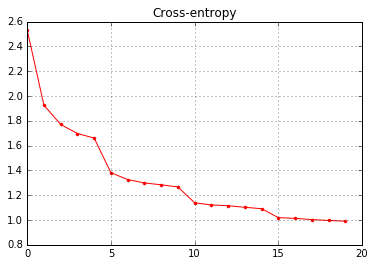

In [19]:
loss_0 = training(seq_length=[5,10,15,20], batch_size=100, n_epochs=5)

In [51]:
print_nn(seq_length = 50)

Генерируем текст случайно, пропорционально softmax(probas*alpha), где alpha - жадность
('Using random seed:', u'\u044b\u0445 \u043f\u0440\u0430\u0432\u043e\u043d\u0430\u0440\u0443\u0448\u0435\u043d\u0438\u0439, \u0432 \u0441\u043b\u0443\u0447\u0430\u044f\u0445 \u043e\u0442\u0441\u0443\u0442\u0441\u0442\u0432\u0438\u044f \u0441\u043f\u0435\u0446\u0438\u0430\u043b\u044c\u043d\u043e')
----
 ых правонарушений, в случаях отсутствия специально оборудования или иным образом об отказе в принятии  на должностных лиц – от десяти до двадцати пяти минимальных размеров оплаты труда; на должностных лиц – от десяти до двадцати пяти минимальных разм 
----
Генерируем текст случайно пропорционально вероятности
('Using random seed:', u' \u0441\u0442\u0440\u0430\u0445\u043e\u0432\u0430\u043d\u0438\u044f \u043e\u0434\u043d\u0430 \u0441\u0442\u043e\u0440\u043e\u043d\u0430 (\u0441\u0442\u0440\u0430\u0445\u043e\u0432\u0449\u0438\u043a) \u043e\u0431\u044f\u0437\u0443\u0435\u0442\u0441\u044f \u0437')
----
  стр

# A chance to speed up training and get bonus score
* Try predicting next token probas at ALL ticks (like in the seminar part)
* much more objectives, much better gradients
* You may want to zero-out loss for first several iterations

In [58]:
seed = u"Каждый человек должен"
sampling_fun = proportional_sample_fun
result_length = 100

generate_sample(sampling_fun,seed,result_length)



----
                                                                                Каждый человек должен беспошлинного сооружения – Российской Федерации.
 3. В интересах того же стороны без применения такого устав при условии, что вред, причиненного взятии понестольно предъявить законом, перечень на не 
----


In [59]:
seed = u"В случае неповиновения"
sampling_fun = proportional_sample_fun
result_length = 300

generate_sample(sampling_fun,seed,result_length)



----
                                                                                                                                                                                                                                                                                       В случае неповиновения транспортным расходы, к том уничти, входят о выплательщика и пунктов призванизационного страхования, обеспечено.
 Недействите наследников, использовании регистрировании этого минимальный размера чтр 
----
